In [2]:
# run ipython with this command in Anaconda Prompt: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import matplotlib
import brewer2mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout,Flatten
from keras.optimizers import SGD
from keras.activations import relu, tanh, elu
from keras.backend import clear_session
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

set3 = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
% matplotlib inline

Using TensorFlow backend.


<font size = 20pt>__Data Visualization Code__</font>

In [3]:
'''
The method creates visualizations of model predictions on test set. It provides class distriubtions, 
images with prediciton results represented by bar charts, confusion matrix and acurracy precision matrix.
@param 
X: features of test set 
y_prob: predicted probability vectors for all test images, with size num_images * 7. Ex: ((0.16, 0.05 ....), (0.07, 0.34,...), ...... )
y_pred: predicted label for all test images, size num_images * 1 Ex: (1, 4, 2, 0, ....)
y_true: true labels for all test images, size num_images * 1 Ex: (1, 2, 2, 3, .....)
labels: names of classes in list of length 7
plot_wrong_prediction: provides the option to plot only wrongly predicted images

'''

def run_visualization(X, y_prob, y_pred, y_true, labels, plot_wrong_prediction = False):
    # Prediction Results
    def plot_subjects(start, end, X, y_pre, y_tru, labels, title=False):
        fig = plt.figure(figsize=(16,16))
        emotion = dict([[i, labels[i]] for i in range(len(labels))])
        for i in range(start, end+1):
            input_img = X[i,:,:,:]
            ax = fig.add_subplot(10, 7, i+1)
            ax.imshow(input_img[:,:,0], cmap=matplotlib.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            if y_pre[i] != y_tru[i]:
                plt.xlabel(labels[y_tru[i]], color='#53b3cb',fontsize=12)
            else:
                plt.xlabel(labels[y_tru[i]], fontsize=12)
            if title:
                plt.title(labels[y_pre[i]], color='blue')
            plt.tight_layout()
        plt.show()
    
    def plot_probs(start,end, X, y_pro, labels):
        fig = plt.figure(figsize=(14,14))
        for i in range(start, end+1):
            input_img = X[i,:,:,:]
            ax = fig.add_subplot(10, 7, i+1)
            ax.bar(np.arange(0,len(labels)), y_pro[i], color=set3,alpha=0.5, edgecolor='black', linewidth=0.5)
            ax.set_xticks(np.arange(0,len(labels),1))
            ax.set_xticklabels(labels, rotation=90, fontsize=10)
            ax.set_yticks(np.arange(0.0,1.1,0.5))
            plt.tight_layout()
        plt.show()
    
    def plot_subjects_with_probs(start, end, X, y_pro, y_pre, y_tru, labels):
        iter = int((end - start)/7)
        for i in range(iter):
            plot_subjects(i*7,(i+1)*7-1, X, y_pre, y_tru, labels, title=False)
            plot_probs(i*7,(i+1)*7-1, X, y_pro, labels)
    
    
    def plot_distribution(y_true, y_pred, labels):
        ind = np.arange(1,len(labels) + 1,1)  # the x locations for the groups
        width = 0.4
        fig, ax = plt.subplots()
        true = ax.bar(ind, np.bincount(y_true) / len(y_true) * 100, width, color=set3, alpha=1.0, edgecolor='black', linewidth=1)
        pred = ax.bar(ind + width, np.bincount(y_pred) / len(y_pred) * 100, width, color=set3, alpha=0.3, edgecolor='black', linewidth=1)
        ax.set_xticks(np.arange(1,len(labels) + 1,1))
        ax.set_xticklabels(labels, rotation=30, fontsize=14)
        ax.set_xlim([1.5 * width, len(labels) + 1 - 0.5*width])
        ax.set_title('True and Predicted Label Count')
        plt.tight_layout()
        plt.show()
    

    def plot_confusion_matrix(y_true, y_pred, labels, cmap=plt.cm.Blues):
        cm = confusion_matrix(y_true, y_pred)
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)
        fig = plt.figure(figsize=(len(labels) + 1,len(labels) + 1))
        matplotlib.rcParams.update({'font.size': 12})
        ax  = fig.add_subplot(111)
        matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
        fig.colorbar(matrix) 
        thresh = 0.5
        for i in range(len(labels)):
            for j in range(len(labels)):  
                ax.text(j,i, str(int(cm[i,j]*100)) + "%",va='center', ha='center', color="white" if cm[i, j] > thresh else "black")
        ax.set_title('Confusion Matrix')
        ticks = np.arange(len(labels))
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    def class_accuracy(y_true, y_pred, emotion):
        cm = confusion_matrix(y_true, y_pred)
        i = [i for i, label in enumerate(labels) if label == emotion][0]
        tp = cm[i,i]
        fn = sum([cm[i,j] for j in range(len(labels)) if j != i])
        fp = sum([cm[j,i] for j in range(len(labels)) if j != i])
        tn = sum([cm[i,j] for j in range(len(labels)) for i in range(0,len(labels)-1)]) -(tp+fp+fn)
        return float(tp + tn)/sum([tp, fn, fp, tn])
    
    if plot_wrong_prediction:                                                 #plot probability with input image of only wrong prediction
        idx = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i]]
        tempx = test_data_x[idx,:,:,:]
        tempy = [y_prob[i] for i in idx]
        temppred = [y_pred[i] for i in idx]
        temptrue = [y_true[i] for i in idx]
        plot_subjects_with_probs(0, 36, tempx, tempy, temppred, temptrue, labels)
    else:
        plot_distribution(y_true, y_pred, labels)                                     #plot true and predicted value distribution
        plot_subjects_with_probs(0, 36, X, y_prob, y_pred, y_true, labels)    #plot probability with input image
        print("\n\n       Accuracy of Training\n")
        for emotion in labels:                                                        #print accuracy per classification
            print("%10s   acc = %f" % (emotion, class_accuracy(y_true, y_pred, emotion)))
#         print("y_true",len(y_true),y_true[0],"y_pred",len(y_pred),y_pred[0],"targ names", labels[0])
        print("\n" + classification_report(y_true, y_pred, target_names=labels))
        plot_confusion_matrix(y_true, y_pred, labels, cmap=plt.cm.YlGnBu)                     #print confusion matrix

## Load Data (Optional)

In [28]:
train_data_x = pd.read_pickle('normalized_fer2013.pkl')
train_data_y = pd.read_pickle('normalized_fer2013_labels.pkl').astype(int)
test_data_x = pd.read_pickle('normalized_test_fer2013.pkl')
test_data_y = pd.read_pickle('normalized_test_fer2013_labels.pkl').astype(int)

In [29]:
train_data_x = train_data_x.as_matrix().reshape((-1,48,48,1))
test_data_x = test_data_x.as_matrix().reshape((-1,48,48,1))

In [6]:
emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
positive_emotes = [3, 5]
neutral = [6]
negative_emotes = [0, 1, 2, 4]

def relabels(label):
    if label in positive_emotes:
        return -1
    if label == 4:
        return 3
    if label == 6:
        return 4
    return label

test_data_y = test_data_y.apply(relabels)

train_data_y = train_data_y.apply(relabels)

In [30]:
train_data_y = train_data_y.as_matrix()
test_data_y = test_data_y.as_matrix()

In [8]:
emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Sad', 4:'Neutral', -1:'Positives'}
positive_emotes = [-1]
neutral = [4]
negative_emotes = [0, 1, 2, 3]

test_data_x2, test_data_y2 = [], []
for idx in range(len(test_data_y)):
    if test_data_y[idx] in negative_emotes + neutral:
        test_data_x2 += [test_data_x[idx,:,:,:]]
        test_data_y2 += [test_data_y[idx]]

train_data_x2, train_data_y2 = [], []
for idx in range(len(train_data_y)):
    if train_data_y[idx] in negative_emotes + neutral:
        train_data_x2 += [train_data_x[idx,:,:,:]]
        train_data_y2 += [train_data_y[idx]]
        
test_data_x2 = np.array(test_data_x2)
train_data_x2 = np.array(train_data_x2)

In [9]:
train_data_y2 = keras.utils.to_categorical(train_data_y2, num_classes=5)
test_data_y2 = keras.utils.to_categorical(test_data_y2, num_classes=5)

## Load Model (For all models)

In [ ]:
# load in the whole architecture, training methods, and weights with h5 file
addr = "Negatives_32_32_32_32F64_32"
model = load_model(addr + '.h5')

# # load the whole architecture stored in json and create model
# json_file = open(addr + '.json','r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into model from h5 file
# model.load_weights(addr + '.h5')


# evaluate model on test set
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(test_data_x2, test_data_y2, verbose=0)
#print("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [ ]:
# prediction and true labels               ********TAKES SOME TIME TO RUN********
y_prob = model.predict(test_data_x2, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in test_data_y2]

In [38]:
from vote import *
train_pred,test_pred = load_model_npz(['model_{}/preds.npz'.format(i) for i in range(15,31)])
# pred_train = vote(train_pred,train_data_y)
# pred_test = vote(test_pred,test_data_y)

def avg_pool(model_arr):
    s = model_arr[0]
    for i, model in enumerate(model_arr[1:]):
        s = s + model
    s /= (i+1)
    return s

pred_test = avg_pool(train_pred)
y_prob = pred_test
y_pred = np.array([np.argmax(prob) for prob in y_prob])
y_true = train_data_y

In [37]:
np.savez("visualtrain.npz",train_data_x, y_prob, y_pred, y_true, labels)

In [12]:
counts = np.bincount(y_pred)
# labels = ['Angry', 'Disgust', 'Fear', 'Sad', 'Neutral']
emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
labels = [emotion[i] for i in range(7)]
print([[x, y] for x, y in zip(labels, counts)])

[['Angry', 878], ['Disgust', 54], ['Fear', 764], ['Happy', 2022], ['Sad', 1337], ['Surprise', 801], ['Neutral', 1322]]


## Run Visualization (without input model)

In [13]:
test_data_x.shape, y_prob.shape, y_pred.shape, y_true.shape,len(labels)

((7178, 48, 48, 1), (7178, 7), (7178,), (7178,), 7)

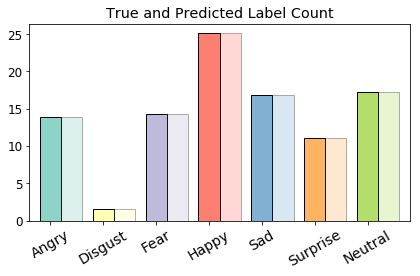

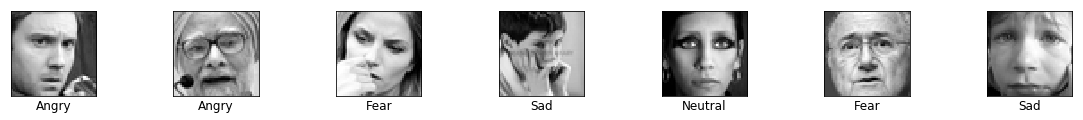

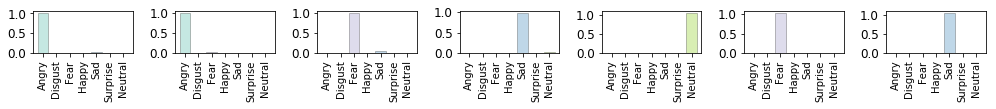

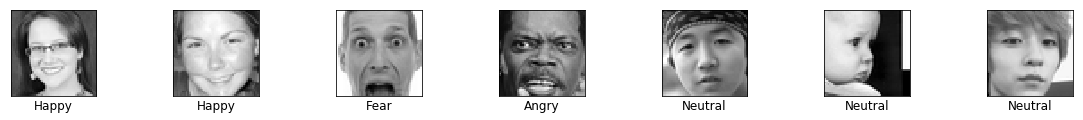

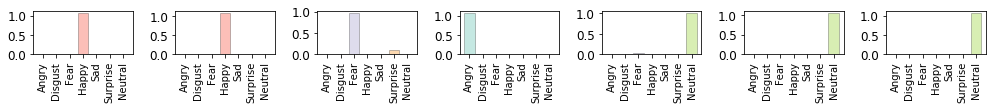

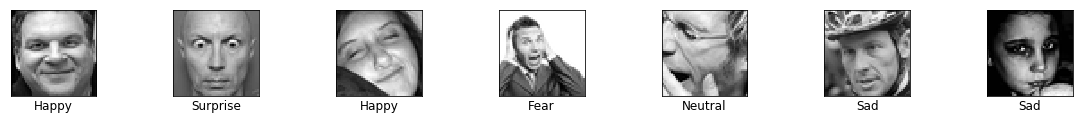

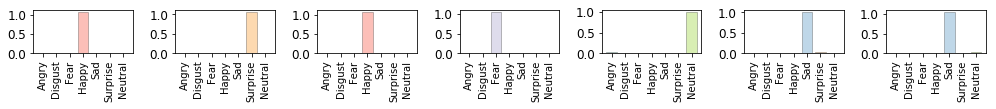

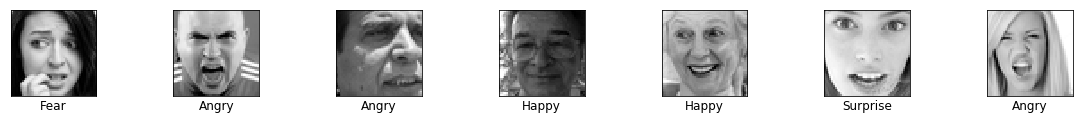

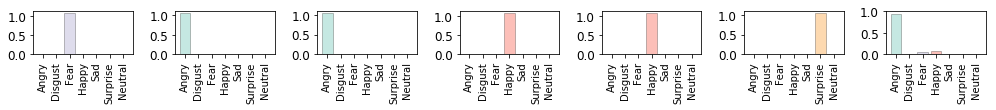

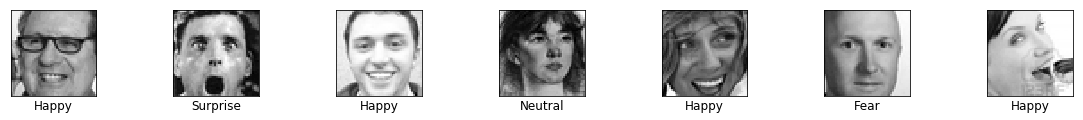

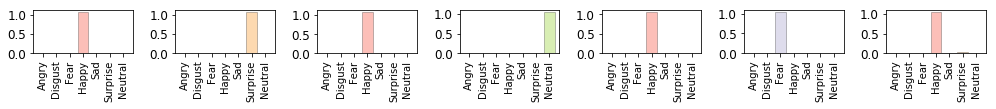



       Accuracy of Training

     Angry   acc = 0.999116
   Disgust   acc = 0.999916
      Fear   acc = 0.998694
     Happy   acc = 0.999916
       Sad   acc = 0.999031
  Surprise   acc = 0.999326
   Neutral   acc = 0.999621
y_true 28709 0 y_pred 28709 0 targ names Angry

             precision    recall  f1-score   support

      Angry       1.00      1.00      1.00      3995
    Disgust       1.00      1.00      1.00       436
       Fear       1.00      1.00      1.00      4097
      Happy       1.00      1.00      1.00      7215
        Sad       1.00      1.00      1.00      4830
   Surprise       1.00      1.00      1.00      3171
    Neutral       1.00      1.00      1.00      4965

avg / total       1.00      1.00      1.00     28709



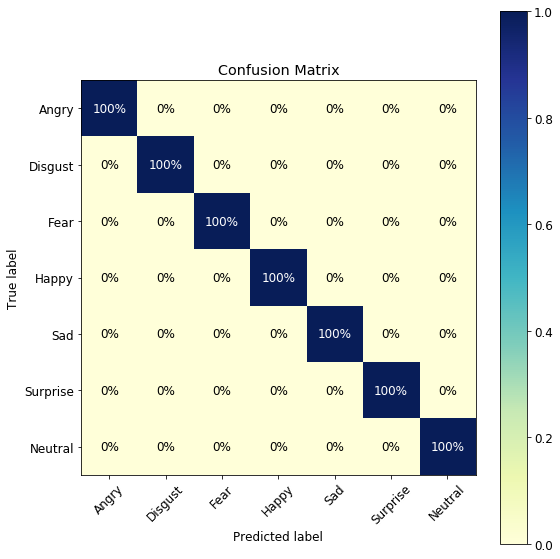

In [40]:
# generate several types of visualization
# only plot first 36 images of test dataset.
run_visualization(train_data_x, y_prob, y_pred, y_true, labels, False)

In [ ]:
# plot only wrongly predicted images, set plot_wrong_predicitons = True
run_visualization(test_data_x2, y_prob, y_pred, y_true, labels, plot_wrong_prediction= True)